# CM4 Analysis — Rounds 1 & 2

This notebook processes Round 1 and Round 2 data, including:
- Classification of speed/stamina/other debuffers
- Per-round win rate breakdowns
- Round 1 vs Round 2 meta differences
- Debuffer count impact on team performance

Inputs:
- Cleaned dataset (data/cleaned/cm4_clean.csv)

Outputs:
- Round visualizations (outputs/figures/)
- Round summary tables (outputs/summary_excel/)


In [22]:
# Core libraries & helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

from pathlib import Path
import sys
sys.path.append("../scripts")
from cm_rounds_utils import *



plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

In [23]:
# load the cleaned or feature-augmented dataset
DATA_PATH = Path("/workspaces/moomooleo/data/cleaned/leo_cm_features.csv")
if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
    print("Loaded feature-augmented data:", df.shape)
else:
    print("WARNING: /workspaces/moomooleo/data/cleaned/leo_cm_features.csv not found. Load your DataFrame into `df` manually.")

Loaded feature-augmented data: (1490, 93)


In [24]:
# --- Style Settings ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")
sns.set_context("talk")

# --- Optional display tweaks for Jupyter ---
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

In [25]:
# Load raw data
df = pd.read_excel("/workspaces/moomooleo/data/raw/CM Data Collection - Leo Cup (Responses).xlsx")

In [26]:
# Columns we care about
keep_cols = [
    "Player IGN",
    "CM Group",
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)"
]

# Add all round columns automatically
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]
for prefix in round_prefixes:
    keep_cols += [c for c in df.columns if c.startswith(prefix)]

# Subset to relevant data only
df = df[keep_cols].copy()

In [27]:
# --------------------
# Columns of interest
# --------------------
prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

# Keep CM Group + LB columns as-is; convert LBs with map (avoids FutureWarning)
lb_map = {"0LB": 0, "1LB": 1, "2LB": 2, "3LB": 3, "MLB": 4}
for col in [
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)",
]:
    if col in df.columns:
        df[col] = df[col].map(lb_map).astype("Int64")  # nullable int, no downcast warning


In [28]:
# --------------------
# Wins / Races per round: numeric (nullable) + Win Rate (%)
# Handle skipped players cleanly.
# --------------------
for p in prefixes:
    win_col  = f"{p} - No. of wins"
    race_col = f"{p} - No. of races played"

    # Create a "Played?" flag from Uma columns
    uma_cols = [f"{p} - Uma {i}" for i in (1, 2, 3) if f"{p} - Uma {i}" in df.columns]
    played_col = f"{p} - Played?"
    if uma_cols:
        df[played_col] = ~df[uma_cols].isna().all(axis=1)
    else:
        df[played_col] = False  # if no uma columns present, assume not played

    # Coerce wins/races to nullable ints, but don't invent zeros
    if win_col in df:
        df[win_col] = pd.to_numeric(df[win_col], errors="coerce").astype("Int64")
    if race_col in df:
        df[race_col] = pd.to_numeric(df[race_col], errors="coerce").astype("Int64")

    # If the player clearly did NOT play this round (no Umas), mark both as NA
    if win_col in df and race_col in df:
        skipped_mask = ~df[played_col]
        df.loc[skipped_mask, [win_col, race_col]] = pd.NA

        # Compute Win Rate only when races > 0
        wr_col = f"{p} - Win Rate (%)"
        df[wr_col] = ((df[win_col] / df[race_col]) * 100).where(df[race_col].gt(0))
        df[wr_col] = df[wr_col].round(2).astype("Float64")

In [29]:
# Confirm LB dtypes are clean, nullable ints
print(df[["Kitasan Black LB in Account (Non-borrow)",
          "Super Creek LB in Account (Non-borrow)"]].dtypes)

# Check a sample of the round metrics + Played?
cols_show = []
for p in prefixes:
    for suffix in ["No. of wins", "No. of races played", "Win Rate (%)", "Played?"]:
        c = f"{p} - {suffix}"
        if c in df.columns:
            cols_show.append(c)

print(df[["CM Group"] + cols_show].head(10))


Kitasan Black LB in Account (Non-borrow)    Int64
Super Creek LB in Account (Non-borrow)      Int64
dtype: object
            CM Group  R1D1 - No. of wins  R1D1 - No. of races played  R1D1 - Win Rate (%)  R1D1 - Played?  R1D2 - No. of wins  R1D2 - No. of races played  R1D2 - Win Rate (%)  \
0  Graded (No Limit)                <NA>                        <NA>                 <NA>           False                <NA>                        <NA>                 <NA>   
1  Graded (No Limit)                  16                          20                 80.0            True                  15                          20                 75.0   
2  Graded (No Limit)                  18                          20                 90.0            True                  16                          20                 80.0   
3  Graded (No Limit)                  11                          20                 55.0            True                  16                          20                 80.0

In [30]:
# --- Gather all Uma + Role pairs from R1D1, R1D2, R2D1, R2D2 ---
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]
role_cols = [f"{p} - Uma {i}" for p in round_prefixes for i in (1,2,3)]
role_cols += [f"{p} - Uma {i} Role" for p in round_prefixes for i in (1,2,3)]

# Get only valid columns
role_cols = [c for c in role_cols if c in df.columns]

# Melt Uma and Role pairs
uma_roles = []
for p in round_prefixes:
    for i in (1, 2, 3):
        uma_col = f"{p} - Uma {i}"
        role_col = f"{p} - Uma {i} Role"
        if uma_col in df.columns and role_col in df.columns:
            temp = df[[uma_col, role_col]].dropna()
            temp.columns = ["Uma", "Role"]
            temp["Uma"] = temp["Uma"].astype(str).str.strip().str.title()
            temp["Role"] = temp["Role"].astype(str).str.strip().str.title()
            uma_roles.append(temp)

uma_roles = pd.concat(uma_roles, ignore_index=True)

# --- Find Umas marked as Debuffers but not in DEBUFF_TYPE ---
mask_debuffer_role = uma_roles["Role"].str.contains("Debuffer", case=False, na=False)
debuffer_umas = uma_roles[mask_debuffer_role]["Uma"].value_counts().rename_axis("Uma").reset_index(name="Count")

# Filter: Debuffers in data but missing in DEBUFF_TYPE mapping
unmapped_debuffers = debuffer_umas[~debuffer_umas["Uma"].isin(DEBUFF_TYPE.keys())]

print("=== Umas marked as Debuffers (Role) but NOT in DEBUFF_TYPE mapping ===")
print(unmapped_debuffers)


=== Umas marked as Debuffers (Role) but NOT in DEBUFF_TYPE mapping ===
                    Uma  Count
6        Narita Taishin      5
7          Special Week      1
8           Rice Shower      1
9             Seiun Sky      1
10  Maruzensky (Summer)      1
11            Oguri Cap      1


In [31]:
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

wr_debuffer_summary = pd.concat(
    [build_round_team_wr_debuffer(df, p) for p in round_prefixes],
    ignore_index=True
)

# Make labels cleaner
wr_debuffer_summary["HasDebuffer"] = wr_debuffer_summary["HasDebuffer"].map(
    {True: "With Debuffer", False: "No Debuffer"}
)

# Sort for nicer display
wr_debuffer_summary = wr_debuffer_summary.sort_values(["Round", "HasDebuffer"])
print(wr_debuffer_summary)


  Round    HasDebuffer  Teams  Wins  Races  WinRate
0  R1D1    No Debuffer    115  1584   2205    71.84
1  R1D1  With Debuffer    781  9957  14855    67.03
2  R1D2    No Debuffer    109  1496   2085    71.75
3  R1D2  With Debuffer    721  8999  13705    65.66
4  R2D1    No Debuffer    103  1156   1950    59.28
5  R2D1  With Debuffer    673  6870  13030    52.72
6  R2D2    No Debuffer    100  1191   1940    61.39
7  R2D2  With Debuffer    666  7173  12860    55.78


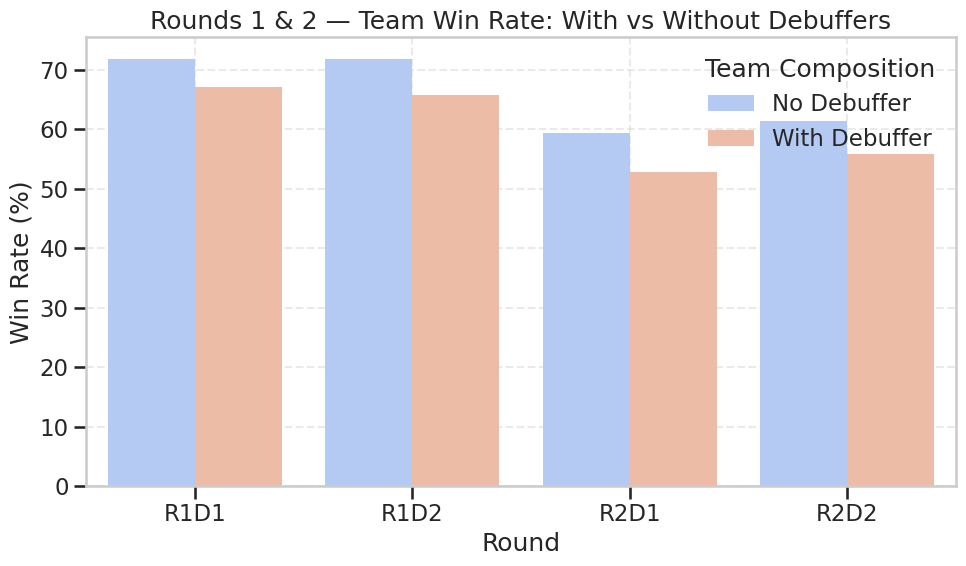

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(data=wr_debuffer_summary, x="Round", y="WinRate", hue="HasDebuffer", palette="coolwarm")
plt.title("Rounds 1 & 2 — Team Win Rate: With vs Without Debuffers")
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Team Composition")
plt.tight_layout()
plt.show()


In [33]:
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

wr_debuffer_type_summary = pd.concat(
    [build_round_team_wr_by_debuffer_type(df, p) for p in round_prefixes],
    ignore_index=True
)

# Clean up order for nice plotting
order = ["No Debuffer", "Speed", "Stamina", "Other", "Mixed"]
wr_debuffer_type_summary["DebufferType"] = pd.Categorical(
    wr_debuffer_type_summary["DebufferType"], categories=order, ordered=True
)

print(wr_debuffer_type_summary.sort_values(["Round","DebufferType"]))


   Round DebufferType  Teams  Wins  Races  WinRate
1   R1D1  No Debuffer    115  1584   2205    71.84
3   R1D1        Speed    263  3503   5060    69.23
4   R1D1      Stamina    351  4621   6660    69.38
2   R1D1        Other      4    53     75    70.67
0   R1D1        Mixed    163  1780   3060    58.17
6   R1D2  No Debuffer    109  1496   2085    71.75
8   R1D2        Speed    270  3477   5175    67.19
9   R1D2      Stamina    305  3941   5810    67.83
7   R1D2        Other      4    41     65    63.08
5   R1D2        Mixed    142  1540   2655    58.00
11  R2D1  No Debuffer    103  1156   1950    59.28
13  R2D1        Speed    276  2970   5375    55.26
14  R2D1      Stamina    261  2716   5035    53.94
12  R2D1        Other      3    41     60    68.33
10  R2D1        Mixed    133  1143   2560    44.65
16  R2D2  No Debuffer    100  1191   1940    61.39
18  R2D2        Speed    297  3377   5790    58.32
19  R2D2      Stamina    233  2504   4515    55.46
17  R2D2        Other      3   

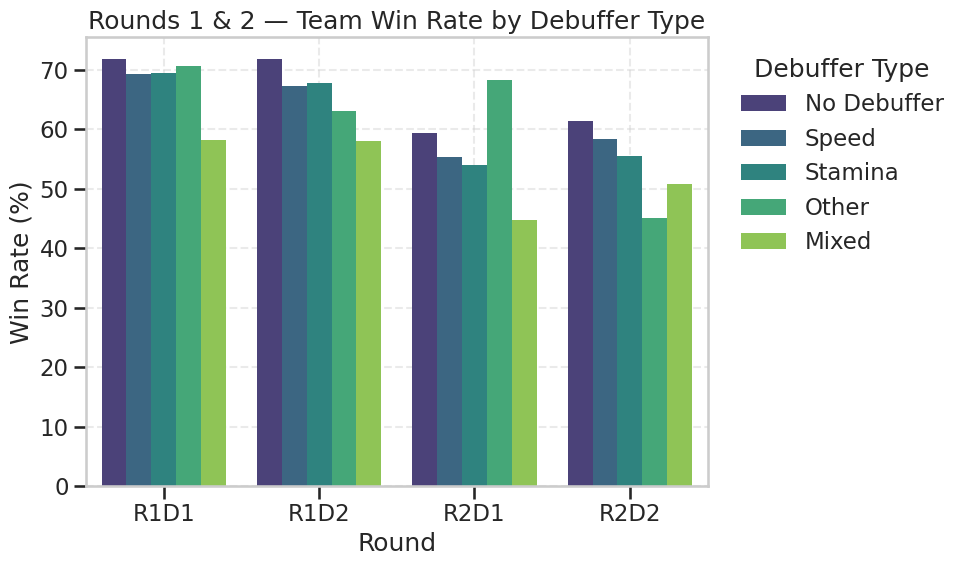

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(data=wr_debuffer_type_summary,
            x="Round", y="WinRate", hue="DebufferType", palette="viridis")
plt.title("Rounds 1 & 2 — Team Win Rate by Debuffer Type")
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [35]:
# Collapse the previous per-round data into overall averages
wr_debuffer_trends = (
    wr_debuffer_type_summary
    .groupby(["Round", "DebufferType"], as_index=False)
    .agg(AvgWinRate=("WinRate", "mean"),
         TotalTeams=("Teams", "sum"))
)

# Sort rounds in logical order
round_order = ["R1D1", "R1D2", "R2D1", "R2D2"]
wr_debuffer_trends["Round"] = pd.Categorical(wr_debuffer_trends["Round"], categories=round_order, ordered=True)
wr_debuffer_trends = wr_debuffer_trends.sort_values(["DebufferType", "Round"])

wr_debuffer_trends.head()


/tmp/ipykernel_9038/3629225885.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Round", "DebufferType"], as_index=False)


,Round,DebufferType,AvgWinRate,TotalTeams
0,R1D1,No Debuffer,71.84,115
5,R1D2,No Debuffer,71.75,109
10,R2D1,No Debuffer,59.28,103
15,R2D2,No Debuffer,61.39,100
1,R1D1,Speed,69.23,263


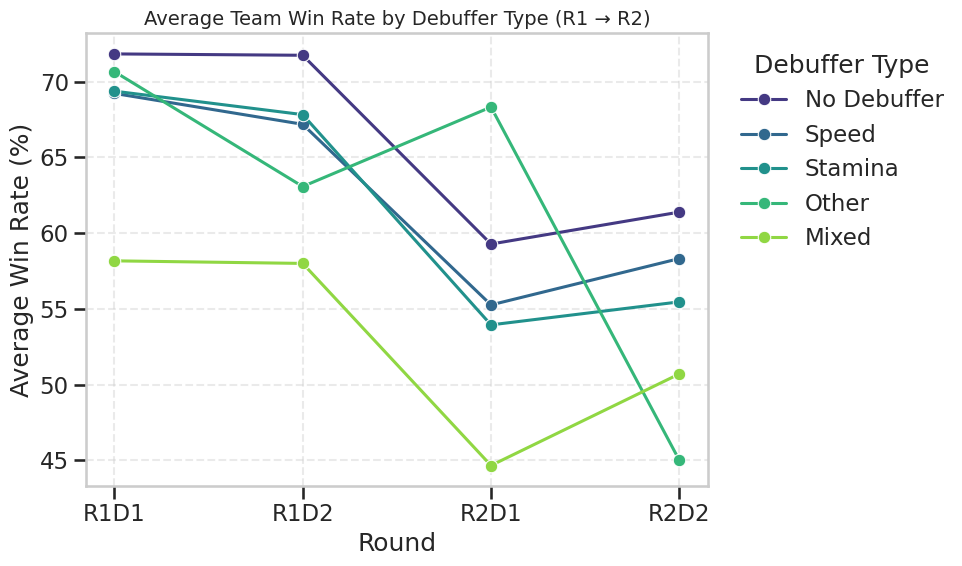

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=wr_debuffer_trends,
    x="Round", y="AvgWinRate", hue="DebufferType", 
    marker="o", linewidth=2.2, palette="viridis"
)
plt.title("Average Team Win Rate by Debuffer Type (R1 → R2)", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Debuffer Type", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


In [37]:
# Compute overall averages across all rounds
overall_avg_wr = (
    wr_debuffer_trends.groupby("DebufferType", as_index=False)
    .agg(
        OverallAvgWR=("AvgWinRate", "mean"),
        TotalTeams=("TotalTeams", "sum")
    )
    .sort_values("OverallAvgWR", ascending=False)
)

print(overall_avg_wr)


  DebufferType  OverallAvgWR  TotalTeams
0  No Debuffer       66.0650         427
1        Speed       62.5000        1106
3        Other       61.7700          14
2      Stamina       61.6525        1150
4        Mixed       52.8800         571


/tmp/ipykernel_9038/1845734649.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wr_debuffer_trends.groupby("DebufferType", as_index=False)


In [39]:
# --- Ensure normalizer exists (Hybrid → Debuffer) ---
try:
    normalize_role
except NameError:
    def normalize_role(x):
        import pandas as pd, numpy as np
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if "debuffer" in s or "hybrid" in s or "domin" in s:  # dominator etc.
            return "Debuffer"
        if "ace" in s: return "Ace"
        return "Other"

# --- Build debuffer-only long table from R1/R2, using Role columns ---
round_prefixes = ["R1D1", "R1D2", "R2D1", "R2D2"]

rows = []
for p in round_prefixes:
    for i in (1, 2, 3):
        uma_col  = f"{p} - Uma {i}"
        role_col = f"{p} - Uma {i} Role"
        if uma_col in df.columns and role_col in df.columns:
            t = df[[uma_col, role_col]].dropna(subset=[role_col]).copy()
            t.columns = ["Uma", "Role"]
            # keep ONLY rows where that slot is actually marked as Debuffer (incl. Hybrid)
            t["RoleNorm"] = t["Role"].apply(normalize_role)
            t = t[t["RoleNorm"] == "Debuffer"].drop(columns=["RoleNorm"])
            if not t.empty:
                t["Uma"] = (t["Uma"].astype(str).str.strip()
                            .str.replace(r"\s+", " ", regex=True)
                            .str.title())
                t["Round"] = p
                t["Slot"]  = i
                rows.append(t)

debuffer_long = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["Uma","Role","Round","Slot"])

# --- Map to Speed / Stamina / Other via your DEBUFF_TYPE ---
# (DEBUFF_TYPE must contain only debuffer Umas with labels "Speed"/"Stamina"/"Other")
debuffer_long["Debuff Type"] = debuffer_long["Uma"].map(DEBUFF_TYPE)

# Split into mapped vs unmapped (still debuffers by Role, but not in your dictionary)
mapped_mask = debuffer_long["Debuff Type"].notna()
debuffer_long_mapped   = debuffer_long[mapped_mask].copy()
unmapped_debuffer_long = debuffer_long[~mapped_mask].copy()

# --- Counts: only debuffers (mapped) ---
debuffer_uma_counts = (
    debuffer_long_mapped
      .groupby(["Debuff Type","Uma"], as_index=False)
      .size()
      .rename(columns={"size":"Appearances"})
      .sort_values(["Debuff Type","Appearances","Uma"], ascending=[True, False, True])
)

# Totals per type (mapped only)
debuffer_type_totals = (
    debuffer_uma_counts.groupby("Debuff Type", as_index=False)["Appearances"].sum()
      .rename(columns={"Appearances":"Type Total"})
)

# Unmapped debuffer Umas (so you can update DEBUFF_TYPE)
unmapped_debuffer_counts = (
    unmapped_debuffer_long.groupby("Uma", as_index=False)
      .size().rename(columns={"size":"Appearances"})
      .sort_values(["Appearances","Uma"], ascending=[False, True])
)

# === Export (overwrite) Excel with the 4 sheets + unmapped block appended ===
out_xlsx = "/workspaces/moomooleo/data/lookup_tables/Debuffer_WR_Comparison_R1_R2.xlsx"

with pd.ExcelWriter(out_xlsx, engine="xlsxwriter", mode="w") as writer:
    # 1) Per-round WR by type
    wr_debuffer_type_summary.to_excel(writer, index=False, sheet_name="PerRound_WR_ByType")
    # 2) Trends
    wr_debuffer_trends.to_excel(writer, index=False, sheet_name="Trends")
    # 3) Overall
    overall_avg_wr.to_excel(writer, index=False, sheet_name="Overall")
    # 4) Debuffer_Umas (mapped only)
    debuffer_uma_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas")

    ws = writer.sheets["Debuffer_Umas"]
    # Append per-type totals a few rows below
    start_row = len(debuffer_uma_counts) + 3
    debuffer_type_totals.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row)

    # If there are any unmapped debuffers, append them too
    if not unmapped_debuffer_counts.empty:
        start_row_unmapped = start_row + len(debuffer_type_totals) + 3
        ws.write_string(start_row_unmapped - 1, 0, "Unmapped Debuffer Umas (by Role, not in DEBUFF_TYPE):")
        unmapped_debuffer_counts.to_excel(writer, index=False, sheet_name="Debuffer_Umas", startrow=start_row_unmapped)

    # Autofit columns on all sheets
    for sheet_name, df_ in {
        "PerRound_WR_ByType": wr_debuffer_type_summary,
        "Trends": wr_debuffer_trends,
        "Overall": overall_avg_wr,
        "Debuffer_Umas": debuffer_uma_counts,
    }.items():
        ws2 = writer.sheets[sheet_name]
        for col_idx, col in enumerate(df_.columns):
            max_len = max(len(str(col)), *(len(str(v)) for v in df_[col].astype(str).values[:1000]))
            ws2.set_column(col_idx, col_idx, min(max_len + 2, 40))

print(f"✅ Debuffer-only counts exported to Debuffer_Umas (mapped), with totals; unmapped debuffers listed below if any → {out_xlsx}")


ModuleNotFoundError: No module named 'xlsxwriter'